# Remote Sensing Analysis of Mangrove Forest in Baie de Grand-Pierre, Artibonite, Haiti

In [7]:
import os
import gc
import json
import glob
import tarfile
import pyproj
import math
import itertools

import cv2 as cv
import numpy as np
import xarray as xr
import rasterio as rs
import rioxarray as rxr
import pandas as pd
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from natsort import natsorted
from datetime import datetime
from matplotlib import colors as colors_mat
import matplotlib.patches as mpatches
import matplotlib.cm as cm

## AOI selection

In [68]:
aoi_list = ['coast_NW', 'coast_N', 'horn', 'coastline_gonave', 'marsh_E', 'marsh_W']
#aoi_list = ['west','east','barrier', 'coast_marsh_S']

def aoi_path(name):
    return '../shapefiles/'+name+'.shp'

## PlanetLabs Data Analysis

### Planet Data GeoTIFFs acquisition

In [70]:
dir = '../Planet/'
#dir = '../Planet_Caracol/'
times = []
sites = []
resSites = []
unmasked_sites = []
for area in aoi_list:
    unmasked_obs = []
    obs = []
    res = []
    aoi = gpd.read_file(aoi_path(area))
    for entry in os.scandir(dir):
        times.append(entry.path)
        ob = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        ob_copy = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        res.append(ob.rio.resolution()[0])
        obs.append(ob)
        unmasked_obs.append(ob_copy)
    sites.append(obs)
    unmasked_sites.append(unmasked_obs)
    resSites.append(res)

## NDWI Masking

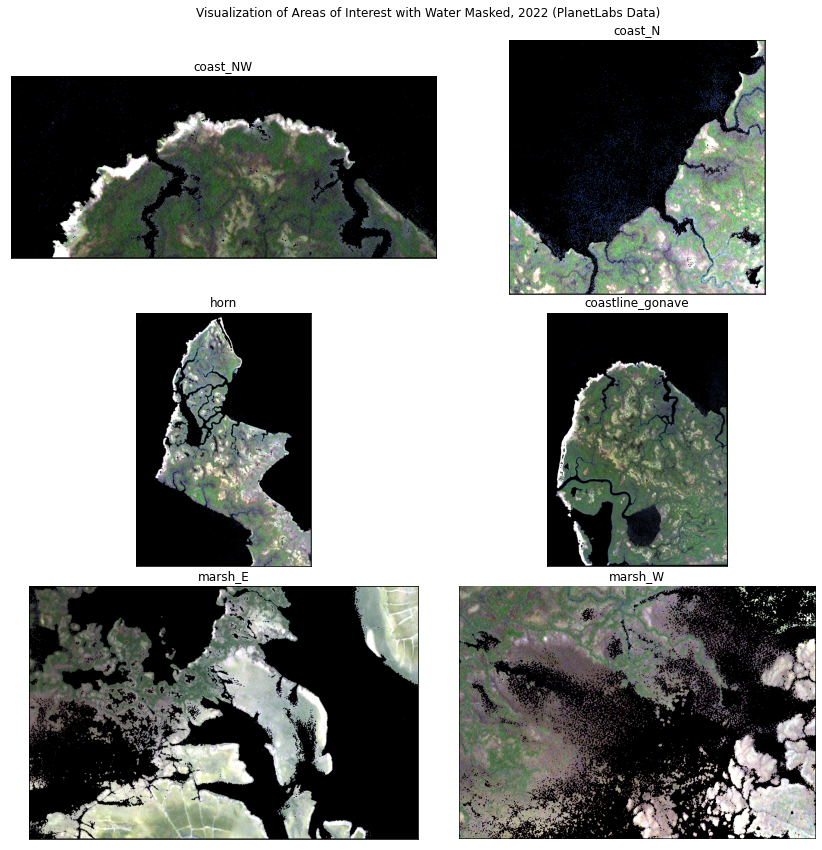

In [217]:
# NDWI = (green - nir)/(green + nir) McFeeters (1996)

#NDWI masks
ndwi_masks = []
for site in sites:
    for obs in site:
        try:
            ndwi = (obs[1]-obs[4])/(obs[1]+obs[4])
        except:
            ndwi = (obs[1]-obs[3])/(obs[1]+obs[3])
        ndwi_masks.append(ndwi)

# Masking water out of observations
count = 0
mask_count = 0
for site in sites:
    for i,obs in enumerate(site):
        for j,band in enumerate(obs):
            ### NDWI Masking Interpretation
            band = np.ma.masked_where(ndwi_masks[mask_count] > 0, band)
            obs[j] = np.nan_to_num(band)
            ###
            count+=1
            #obs[j] = np.nan_to_num(band)        
        mask_count+=1    

fig, axs = plt.subplots(3,2, figsize=(12,12))
fig.suptitle('Visualization of Areas of Interest with Water Masked, 2022 (PlanetLabs Data)')
axs = list(itertools.chain.from_iterable(axs))
for i, site in enumerate(sites):
    ep.plot_rgb(sites[i][0], rgb=[2,1,0], title=aoi_list[i], stretch=True,
            str_clip=1.5, ax=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout(h_pad=0)

plt.show()


## Automated Coastline Detection

Data Reshaping into Vectors for ML use (Vectorizing bands for use in ML as they cant directly use matrices)

In [75]:
reshapedSites = []
for site in sites:
    acqVecs = []
    reshapedVecs = []
    shapes = []
    for ob in site:
        shapes.append(ob.shape)
        acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in ob]
        acqVecs.append(acq)
    for i, acq in enumerate(acqVecs):
        resh = np.array(acq).reshape(shapes[i][0], shapes[i][1]*shapes[i][2]).transpose()
        reshapedVecs.append(resh)
    reshapedSites.append(reshapedVecs)

Segmentation and Clustering

In [76]:
# Segmenting through k-means
modelSites = []

#acquisitions = [planet]
print('Entering site...')
for reshapedVecs in tqdm(reshapedSites):
    models = []
    print('Fitting model...')
    # Excluding first 2 bands (blue and green) as mangroves do not pop out in them and they confuse the clustering
    for resh in tqdm(reshapedVecs):
        model = KMeans(3, n_init=30, random_state=0)
        model.fit(resh[:,2:])
        models.append(model)
    modelSites.append(models)

Entering site...


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

In [77]:
# Creating clusters
clusterSites = []
for i, modelsite in tqdm(enumerate(modelSites)):
    try:
        cluster = [modelsite[i].predict(resh[:,2:]) for i,resh in enumerate(reshapedSites[i])]
    except:
        cluster = [modelsite[i].predict(resh[:,2:]) for i,resh in enumerate(reshapedSites[i])]
    clusterSites.append(cluster)

0it [00:00, ?it/s]

Canny Edge Detection

In [78]:
imageSites = []
blurredSites = []

for i, clusters in enumerate(clusterSites):
    clusteredImages = [clusterLabels.reshape(sites[i][j][0].shape).astype("uint8") for j, clusterLabels in enumerate(clusters)]
    blurredImages = [cv.GaussianBlur(clusteredImage, (3,3), 0) for clusteredImage in clusteredImages]
    imageSites.append(clusteredImages)
    blurredSites.append(blurredImages) 
# Remove last subplot as we have an odd number of subplots
#fig.delaxes(axs[-1]) 

Cover Mapping from CannyEdgeBlurred (better for visualizing and comparing mangrove cover)

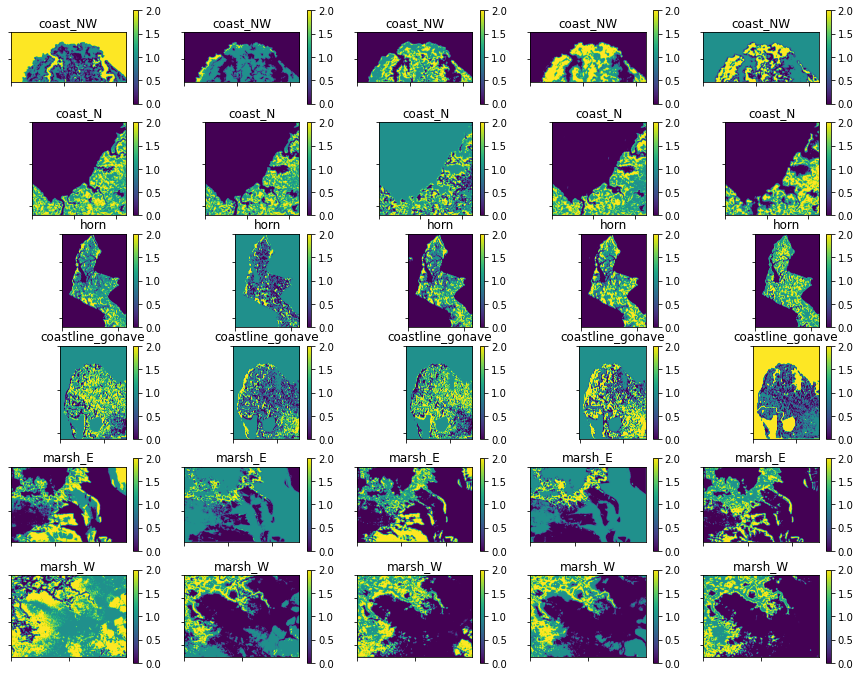

In [208]:
fig, axs = plt.subplots(6,5, figsize=(15,12))
axs = list(itertools.chain.from_iterable(axs))
count = 0
for j,blur in enumerate(blurredSites):
    for ob in blur:
        nd = axs[count].imshow(ob)
        axs[count].set_xticklabels([])
        axs[count].set_yticklabels([])
        axs[count].set_title(aoi_list[j])
        plt.colorbar(nd, ax = axs[count])
        count+=1
plt.show()


As I have not found a way to implement consistency on what is being categorized as 1 or 0s from Kmeans, I have manually determined what is being categorized as water (by plotting) and set up a matrix to mask out water iteratively in the next steps.

In [99]:
water_mask_matrix = [[2,0,0,0,1], [0,0,1,0,0], [0,1,0,0,0], [1,1,1,1,2], [0,1,0,1,0], [1,0,0,0,0]]
ground_mask_matrix = [[0,2,2,1,0], [2,2,2,2,1], [1,0,1,1,2], [2,0,0,0,0], [1,0,2,0,2], [2,1,2,1,2]]
#mask_matrix = [[0,1,0], [0,0,0], [0,0,0], [0, 1, 1, 0, 1], [0, 1, 0, 0, 0], [0, 1, 0, 1, 0]]

Matrix Masking
(This method seems good to visualize loss of coastline and mangrove cover, but does a poor job of showing mangrove advancing. Also, is not great in marsh_E AOI.)

In [100]:
maskSites = []
for i,blur in enumerate(blurredSites):
    shape = sites[i][-1].shape
    dim = (shape[2], shape[1])
    blur[0] = cv.resize(blur[0], dim, interpolation=cv.INTER_AREA)
    blur[1] = cv.resize(blur[1], dim, interpolation=cv.INTER_AREA)
    blur[2] = cv.resize(blur[2], dim, interpolation=cv.INTER_AREA)
    # Masking water out using mask matrix
    masks = [np.ma.masked_where(bl == water_mask_matrix[i][j], bl) for j,bl in enumerate(blur)]
    masks = [np.ma.masked_where(mask == ground_mask_matrix[i][j], mask) for j,mask in enumerate(masks)]
    #masks2 = [np.ma.masked_where(bl == ground_mask_matrix[i][j], bl) for j,bl in enumerate(masks1)]
    maskSites.append(masks)

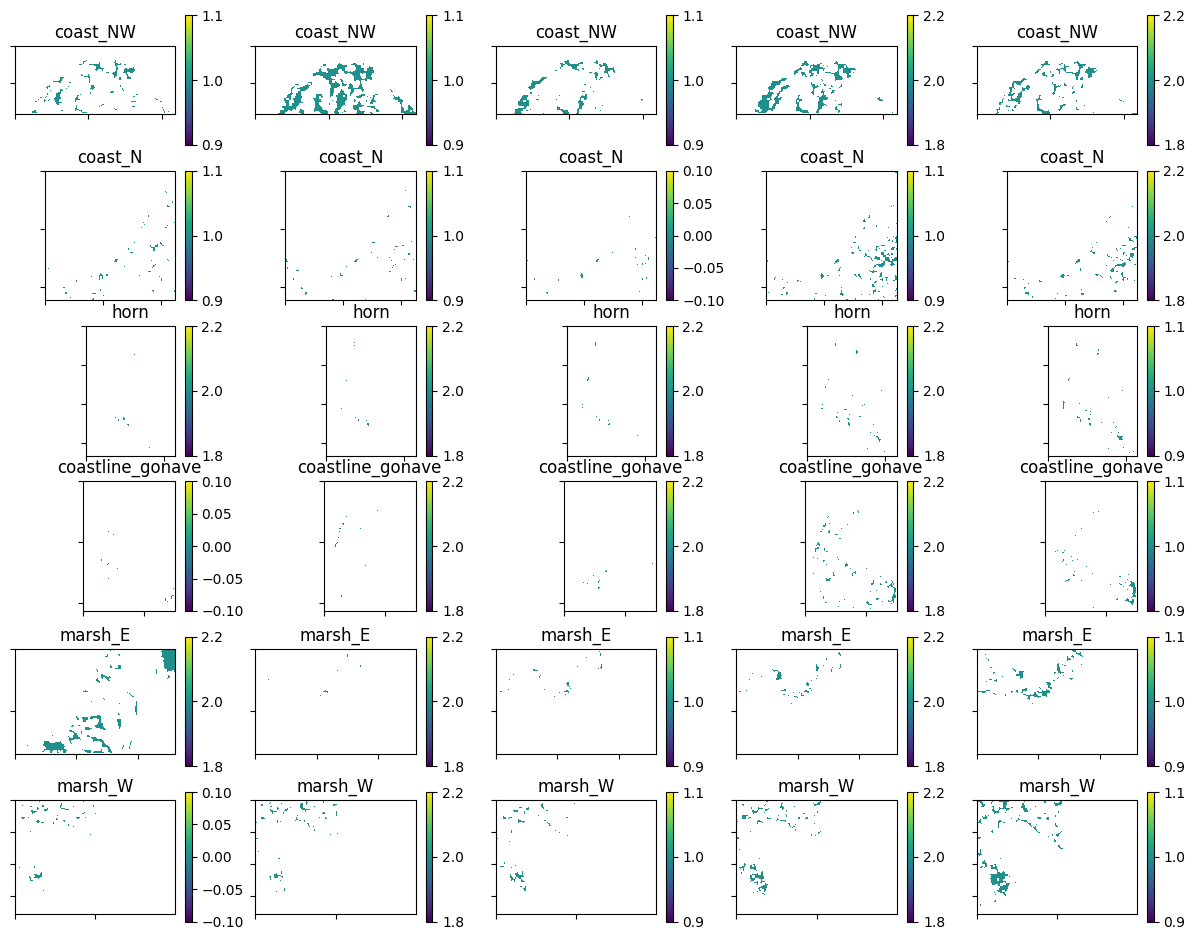

In [207]:
fig, axs = plt.subplots(6,5, figsize=(15,12), dpi=100)
axs = list(itertools.chain.from_iterable(axs))
count = 0
for j,blur in enumerate(maskSites):
    for ob in blur:
        nd = axs[count].imshow(ob)
        axs[count].set_xticklabels([])
        axs[count].set_yticklabels([])
        axs[count].set_title(aoi_list[j])
        plt.colorbar(nd, ax = axs[count])
        count+=1
plt.show()

Coastline and Mangrove Cover Change

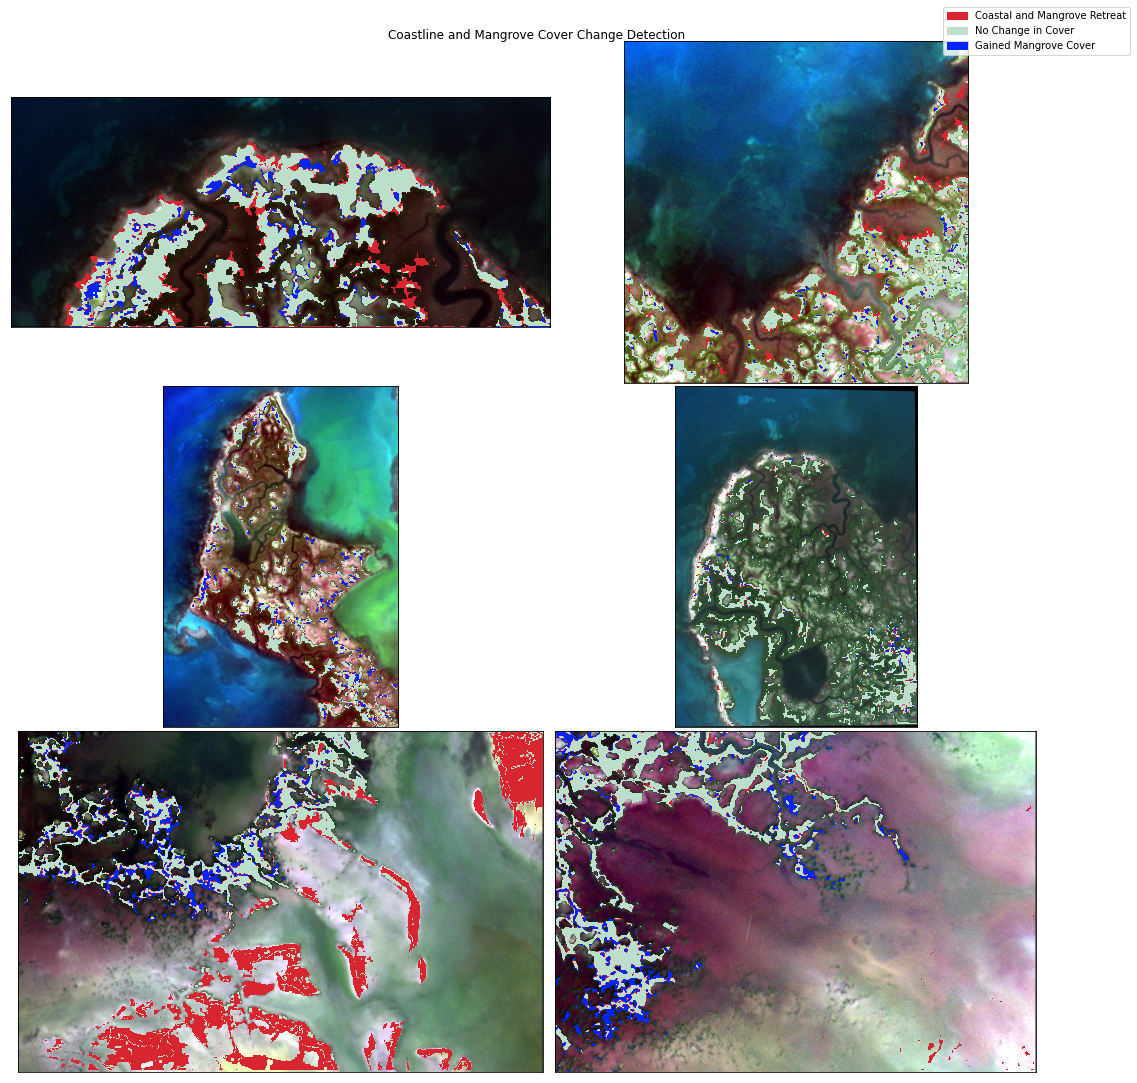

In [216]:
fig, axs = plt.subplots(3,2, figsize=(15,15))
axs = list(itertools.chain.from_iterable(axs))
custom_cmap = colors_mat.ListedColormap(['#0025FC', '#D7262F', '#BBDFCB'])
boundaries = [0, 2, 4, 6]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)
#colors = [cm.get_cmap(value) for value in custom_cmap]

for i,site in enumerate(blurredSites):
    ep.plot_rgb(unmasked_sites[i][-1], rgb=[2,1,0], stretch=True,
            str_clip=.9, ax=axs[i])
    # Apply the blurred Image mask to NDVI !!!!!
    first = np.where(site[0] == maskSites[i][0], 4, 0)
    last = np.where(site[-1] == maskSites[i][-1], 2, 0)
    #first = maskSites[i][0]
    #last = maskSites[i][-1]
    change = first + last
    change_mask = np.ma.masked_where(change == 0, change)
    axs[i].imshow(change_mask, cmap=custom_cmap)
    axs[i].set_title(aoi_list[i])

patches = [mpatches.Patch(color='#D7262F', label='Coastal and Mangrove Retreat'),
            mpatches.Patch(color='#BBDFCB', label='No Change in Cover'),
            mpatches.Patch(color='#0025FC', label='Gained Mangrove Cover')]
fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
fig.suptitle('Coastline and Mangrove Cover Change Detection')
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout(h_pad=0,w_pad=0)
plt.show()

### Mangrove Extent Metrics

Counting Pixels to quantify gross mangrove cover loss.

In [136]:
pixelSites = []
areaSites = []
for i, mask in enumerate(maskSites):
    pixels = [np.size(m.mask) - np.count_nonzero(m.mask) for m in mask]
    pixelSites.append(pixels)

changeSites = []
percChangeSites = []
for i, pixels in enumerate(pixelSites):
    surfaces = [(3**2)*pixels[j] for j, res in enumerate(resSites[i])]
    areaSites.append(surfaces)
    change = (surfaces[-1] - surfaces[0])/(1e6)
    percent = (change*100)/(surfaces[0]/1e6)
    changeSites.append(change)
    percChangeSites.append(percent)

areaSites = np.array(areaSites)
changeSites = np.array(changeSites)
df_change = pd.DataFrame({'AOI': aoi_list,
                'Cover Change (km^2)': changeSites,
                'Percent Change (%)': percChangeSites})
df_change

,AOI,Cover Change (km^2),Percent Change (%)
0,coast_NW,-0.140058,-13.627209
1,coast_N,-0.361818,-17.083826
2,horn,1.215585,71.309403
3,coastline_gonave,2.147877,45.248708
4,marsh_E,-0.604512,-29.301703
5,marsh_W,0.511362,78.944590


2nd Moment of Area  against x-axis for Cover + Sparsity Change

In [108]:
secMOAs = []
changeMOA = []
percMOA = []

for j in range(5):
    moa_yr = []
    for i, site in enumerate(maskSites):
        pixels = [np.size(row) - np.count_nonzero(row) for row in site[j]]
        distances = [3*((site[j].shape[0])/2 - 1 - k) for k in range(len(site[j]))]
        moa = 0
        for l,pixel in enumerate(pixels):
            moa += (3**2)*pixel * distances[l]**2 
        moa_yr.append(moa)
    secMOAs.append(moa_yr)


changeMOA = [secMOAs[-1][i] - secMOAs[0][i] for i in range(len(secMOAs[0]))]
percMOA = [(change*100)/(secMOAs[0][i]) for i, change in enumerate(changeMOA)]
    
df_MOA = pd.DataFrame({'AOI': aoi_list, 'Y1': secMOAs[:][0], 'Y2': secMOAs[:][1], 'Y3': secMOAs[:][2], 'Y4': secMOAs[:][3], 'Y5': secMOAs[:][4],
                '2MOAx Change (2022-2012)': changeMOA,
                '2MOAx Percent Change (%)': percMOA})

df_MOA

,AOI,Y1,Y2,Y3,Y4,Y5,2MOAx Change (2022-2012),2MOAx Percent Change (%)
0,coast_NW,1.465371e+11,5.291449e+11,4.791655e+11,4.681558e+11,1.169475e+11,-2.958958e+10,-20.192554
1,coast_N,5.965127e+12,6.298476e+12,1.293859e+12,5.992049e+12,6.509162e+12,5.440354e+11,9.120266
2,horn,2.673864e+13,4.376721e+12,2.726680e+13,2.663326e+13,2.680059e+13,6.194769e+10,0.231679
3,coastline_gonave,1.360910e+13,1.268461e+13,1.353003e+13,1.093806e+13,1.461847e+13,1.009365e+12,7.416833
4,marsh_E,2.837206e+12,1.699238e+12,3.342350e+12,2.152924e+12,3.812623e+12,9.754171e+11,34.379494
5,marsh_W,3.094094e+11,1.025550e+12,1.289024e+12,1.077863e+12,1.401233e+12,1.091824e+12,352.873603


2nd Moment of Area  against y-axis for Cover + Sparsity Change

In [109]:
secMOAs_y = []
changeMOA_y = []
percMOA_y = []

for j in range(5):
    moa_yr = []
    for i, site in enumerate(maskSites):
        pixels = [np.size(col) - np.count_nonzero(col) for col in site[j].T]
        distances = [3*(((site[j].T).shape[0])/2 - 1 - k) for k in range(len(site[j].T))]
        moa = 0
        for l,pixel in enumerate(pixels):
            moa += (3**2)*pixel * distances[l]**2 
        moa_yr.append(moa)
    secMOAs_y.append(moa_yr)


changeMOA_y = [secMOAs_y[-1][i] - secMOAs_y[0][i] for i in range(len(secMOAs_y[0]))]
percMOA_y = [(change*100)/(secMOAs_y[0][i]) for i, change in enumerate(changeMOA_y)]
    
df_MOA = pd.DataFrame({'AOI': aoi_list, 'Y1': secMOAs_y[:][0], 'Y2': secMOAs_y[:][1], 'Y3': secMOAs_y[:][2], 'Y4': secMOAs_y[:][3], 'Y5': secMOAs_y[:][4],
                '2MOAy Change (2022-2012)': changeMOA_y,
                '2MOAy Percent Change (%)': percMOA_y})

df_MOA

,AOI,Y1,Y2,Y3,Y4,Y5,2MOAy Change (2022-2012),2MOAy Percent Change (%)
0,coast_NW,4.099812e+11,3.430959e+12,3.276645e+12,3.302196e+12,2.992436e+11,-1.107377e+11,-27.010424
1,coast_N,5.776862e+12,6.215636e+12,1.602783e+12,5.953934e+12,6.579897e+12,8.030346e+11,13.900878
2,horn,1.408129e+13,1.486874e+12,1.417082e+13,1.410481e+13,1.408724e+13,5.952479e+09,0.042272
3,coastline_gonave,7.759480e+12,8.031365e+12,7.367969e+12,6.651198e+12,8.827569e+12,1.068089e+12,13.764961
4,marsh_E,8.151252e+12,2.357659e+12,9.443334e+12,3.679794e+12,9.551954e+12,1.400702e+12,17.183884
5,marsh_W,6.060176e+11,2.052161e+12,2.483432e+12,2.122021e+12,2.854599e+12,2.248581e+12,371.042222


Polar MOA + Gross Cover Change

In [118]:
secMOA_pol = []
changeMOA_pol = []
percMOA_pol = []

for i, year in enumerate(secMOAs):
    moa_yr = [moa_x + secMOAs_y[i][j] for j, moa_x in enumerate(year)]
    secMOA_pol.append(moa_yr)

changeMOA_pol = [secMOA_pol[-1][i] - secMOA_pol[0][i] for i in range(len(secMOA_pol[0]))]
percMOA_pol = [(change*100)/(secMOA_pol[0][i]) for i, change in enumerate(changeMOA_pol)] 

df_analysis = pd.DataFrame({'AOI': aoi_list, 'Gross Cover Change (km^2)': changeSites,
                'Gross Percent Change (%)': percChangeSites,
                'Polar 2MOA Change (2022-2012)': changeMOA_pol,
                'Polar 2MOA Percent Change (%)': percMOA_pol})
df_analysis
    

,AOI,Gross Cover Change (km^2),Gross Percent Change (%),Polar 2MOA Change (2022-2012),Polar 2MOA Percent Change (%)
0,coast_NW,-0.140058,-13.627209,-1.403272e+11,-25.215208
1,coast_N,-0.361818,-17.083826,1.347070e+12,11.472247
2,horn,1.215585,71.309403,6.790017e+10,0.166341
3,coastline_gonave,2.147877,45.248708,2.077454e+12,9.722001
4,marsh_E,-0.604512,-29.301703,2.376119e+12,21.623769
5,marsh_W,0.511362,78.944590,3.340405e+12,364.901327


Metrics Visualization

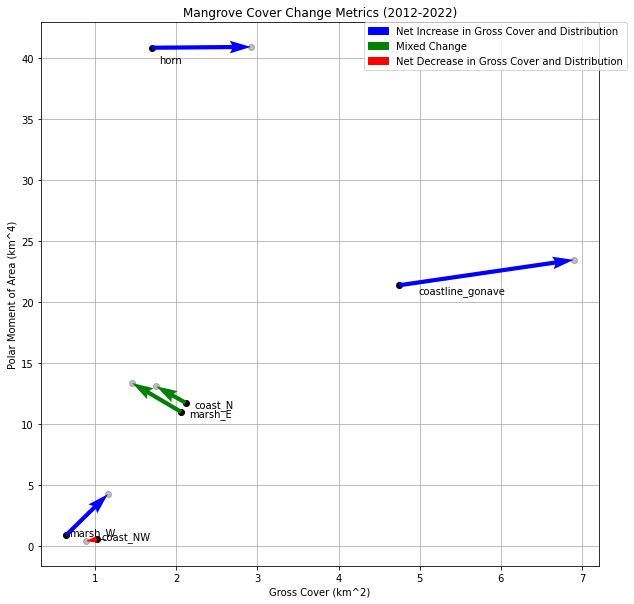

In [211]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Gross Cover (km^2)')
ax.set_ylabel('Polar Moment of Area (km^4)')
# Start positions (X is set of gross covers at Y1, Y is set of 2MOA_pol at Y1)
X = (areaSites.T[0])/1e6
Y = np.array(secMOA_pol[0])/1e12
# Magnitude is distance change (U is for gross cover change, V is for 2MOA change)
U = changeSites
V = np.array(changeMOA_pol)/1e12
# Color code of arrows (blue for increase in both, red for decrease in both, gray for other)
arr_colors = []
for i, change in enumerate(changeSites):
    if change > 0 and changeMOA_pol[i] > 0:
        arr_colors.append('blue')
    elif change < 0 and changeMOA_pol[i] < 0:
        arr_colors.append('red')
    else:
        arr_colors.append('green') 
ax.grid()
ax.scatter(x=X, y=Y, c='k')
ax.scatter(x=areaSites.T[-1]/1e6, y=np.array(secMOA_pol[-1])/1e12, c='k', alpha=0.25)
ax.quiver(X,Y,U,V, color=arr_colors, angles='xy', scale_units='xy', scale=1)
for i, label in enumerate(aoi_list):
    plt.annotate(label, (X[i]+0.05*X[i], Y[i]-0.03*Y[i],))

patches = [mpatches.Patch(color='blue', label='Net Increase in Gross Cover and Distribution'),
            mpatches.Patch(color='green', label='Mixed Change'),
            mpatches.Patch(color='red', label='Net Decrease in Gross Cover and Distribution')]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
ax.set_title('Mangrove Cover Change Metrics (2012-2022)')
ax.patch.set_facecolor('xkcd:white')
ax.set_axisbelow(True)

## dNDVI Analysis

In [106]:
ndviSites = []
for site in sites:
    obs_ndvi = [site[0], site[-1]]
    ndvi = []
    for ob in obs_ndvi:
        red = ob[2]#.fillna(-999)
        try:
            nir = ob[4]#.fillna(-999)
        except:
            nir = ob[3]
        nd = ((nir - red)/(nir + red))#.fillna(-999)
        ndvi.append(nd) 
    ndviSites.append(ndvi)
    

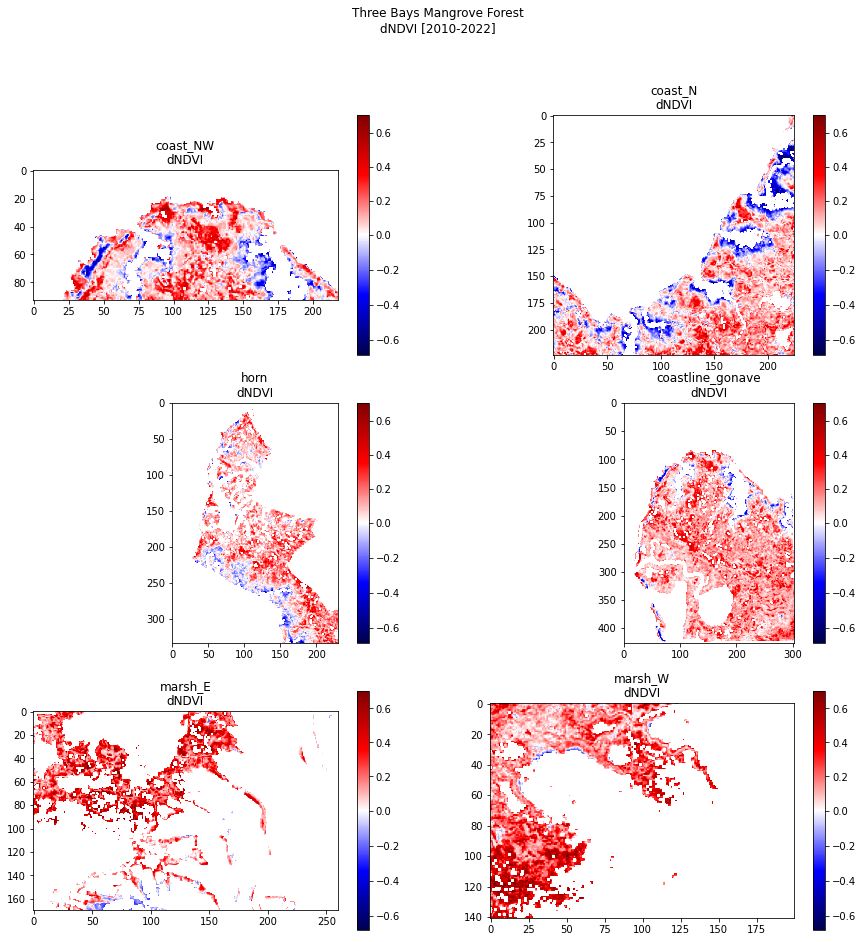

In [107]:
dndvi = [ndvi[1] - ndvi[0] for ndvi in ndviSites]

fig, axs = plt.subplots(3,2, figsize=(15,15))

fig.suptitle("Three Bays Mangrove Forest\ndNDVI [2010-2022]")
axs = list(itertools.chain.from_iterable(axs))
cmaps = ['Set1', 'Pastel2']
divnorm = colors_mat.TwoSlopeNorm(vcenter=0)

for i,diff in enumerate(dndvi):
    #colors = ["darkorange", "black", "lawngreen"]
    #cmap1 = LinearSegmentedColormap.from_list('viridis', colors)
    nd = axs[i].imshow(diff, cmap='seismic', norm=divnorm)
    axs[i].set_title(aoi_list[i]+'\ndNDVI')
    plt.colorbar(nd, ax=axs[i])

plt.show()